<a href="https://colab.research.google.com/github/pragatipatel26/Image-Processing/blob/main/Baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/My Drive/Dataset.zip"
extract_path = "/content/dataset"  # Local extraction folder in Colab

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)



Extracted to: /content/dataset


In [ ]:
import os
for root, dirs, files in os.walk(extract_path):
    print( root)
    for f in files[:5]:  # show only a few files per folder
        print("   └──", f)

/content/dataset
   └── README.dataset.txt
   └── README.roboflow.txt
/content/dataset/train
   └── 9622959c1_jpg.rf.829934e7cc9a8f37416a9fd28666b488.jpg
   └── e89c99064_jpg.rf.702ee180833055c6b69c5f616bc140d6.jpg
   └── 3377332c0_jpg.rf.41379884d1a7244c2dcca33ab7510bf0.jpg
   └── 6f405f1e3_jpg.rf.357dbb6fb6e095a566845d53616ad989.jpg
   └── 2f54e2c00_jpg.rf.7f23eb007bda002f084c1341817b566c.jpg
/content/dataset/valid
   └── e29f1a47a_jpg.rf.1b3dbfd9c1a44a9f07c12e53120e45b3.jpg
   └── 99855ae32_jpg.rf.f2a66dc503280fb4eee79acf841652f9.jpg
   └── 343e101ee_jpg.rf.22d3091a2f68dd8328fba8c67e4e0fbb.jpg
   └── 9b2801e98_jpg.rf.8e03498534069ae49d88ce1a5629bb4f.jpg
   └── 39b2dbb9b_jpg.rf.a34c2a9fefcd7157a88ea96322685ae9.jpg
/content/dataset/test
   └── c319a0d11_jpg.rf.38d2f3378f53434b35fa2e3efa7ae2aa.jpg
   └── 49fa7d0fa_jpg.rf.ef68cbf7e45fa7afceea3a9b883bfb5e.jpg
   └── 06f4583b1_jpg.rf.14b667f5df309d5cae90fd0ab5c5d165.jpg
   └── 8b495e389_jpg.rf.dd76ba62cc432ed30aec8e1c845902d3.jpg
   └── 2

In [ ]:
import glob

# Look for all CSV and Excel files in the dataset directory
csv_files = glob.glob("/content/dataset/**/*.csv", recursive=True)
excel_files = glob.glob("/content/dataset/**/*.xlsx", recursive=True)

print("CSV files found:", csv_files)
print("Excel files found:", excel_files)

CSV files found: ['/content/dataset/train/_annotations.csv', '/content/dataset/valid/_annotations.csv', '/content/dataset/test/_annotations.csv']
Excel files found: []


In [ ]:
import pandas as pd

train_csv = "/content/dataset/train/_annotations.csv"
df_train = pd.read_csv(train_csv)
print("Train CSV columns:\n", df_train.columns)
print("\nSample rows:")
print(df_train.head())


Train CSV columns:
 Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

Sample rows:
                                            filename  width  height  \
0  6212e44a0_jpg.rf.eca9d0d2821273911813398f6cf9b...    512     256   
1  6212e44a0_jpg.rf.eca9d0d2821273911813398f6cf9b...    512     256   
2  43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...    512     256   
3  43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...    512     256   
4  43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...    512     256   

            class  xmin  ymin  xmax  ymax  
0  scratch defect   488   104   493   172  
1  scratch defect   164     1   169    84  
2  scratch defect   212   130   221   184  
3  scratch defect    93   113   107   162  
4  scratch defect   230     0   247    20  


In [ ]:
# Group by filename and take the first class label (assumes all boxes in one image belong to same class)
df_class = df_train.groupby('filename')['class'].first().reset_index()


#df_class['class'] = df_class['class'].str.replace(" defect", "", regex=False)
print(df_class['class'].value_counts())  # See class distribution

# Save for later use
df_class.to_csv("/content/train_labels.csv", index=False)

class
scratch defect           8070
pitted surface defect    1404
patch defect              826
crazing defect            330
Name: count, dtype: int64


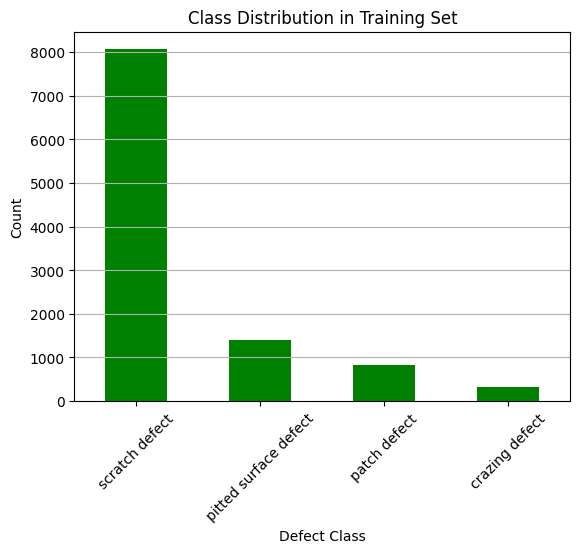

In [ ]:
#visualization of class distribution
import matplotlib.pyplot as plt

df_class['class'].value_counts().plot(kind='bar', color='green')
plt.title("Class Distribution in Training Set")
plt.xlabel("Defect Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
#plt.grid(axis='x')
plt.show()

In [ ]:
#image preprocessing using imagedatagenerator class in keras
IMG_SIZE = (128,128)
BATCH_SIZE = 64

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator(no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
#creation of train,valid and test dataframe
import pandas as pd
import os

# Define base directories
base_dir = "/content/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Load CSV files
train_csv = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
val_csv = pd.read_csv(os.path.join(val_dir, "_annotations.csv"))
test_csv = pd.read_csv(os.path.join(test_dir, "_annotations.csv"))


In [ ]:
# Drop duplicate labels per image
train_df = train_csv[['filename', 'class']].drop_duplicates()
val_df = val_csv[['filename', 'class']].drop_duplicates()
test_df = test_csv[['filename', 'class']].drop_duplicates()


In [ ]:
# Add image paths
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x))
val_df['filepath'] = val_df['filename'].apply(lambda x: os.path.join(val_dir, x))
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))


In [ ]:
print(train_df.head())


                                             filename                  class  \
0   6212e44a0_jpg.rf.eca9d0d2821273911813398f6cf9b...         scratch defect   
2   43b6618bf_jpg.rf.ec7a7bcb21bcc7881051906d564ba...         scratch defect   
5   7a14789e6_jpg.rf.ecc6e737fd543a36d4ea7ed7e85fe...         scratch defect   
7   ed861754e_jpg.rf.ecbd85f351394ff08d10511701ed4...         scratch defect   
13  cefbcc992_jpg.rf.ec92b4ebccf979c2103dd2e918613...  pitted surface defect   

                                             filepath  
0   /content/dataset/train/6212e44a0_jpg.rf.eca9d0...  
2   /content/dataset/train/43b6618bf_jpg.rf.ec7a7b...  
5   /content/dataset/train/7a14789e6_jpg.rf.ecc6e7...  
7   /content/dataset/train/ed861754e_jpg.rf.ecbd85...  
13  /content/dataset/train/cefbcc992_jpg.rf.ec92b4...  


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 11304 validated image filenames belonging to 4 classes.
Found 710 validated image filenames belonging to 4 classes.
Found 707 validated image filenames belonging to 4 classes.


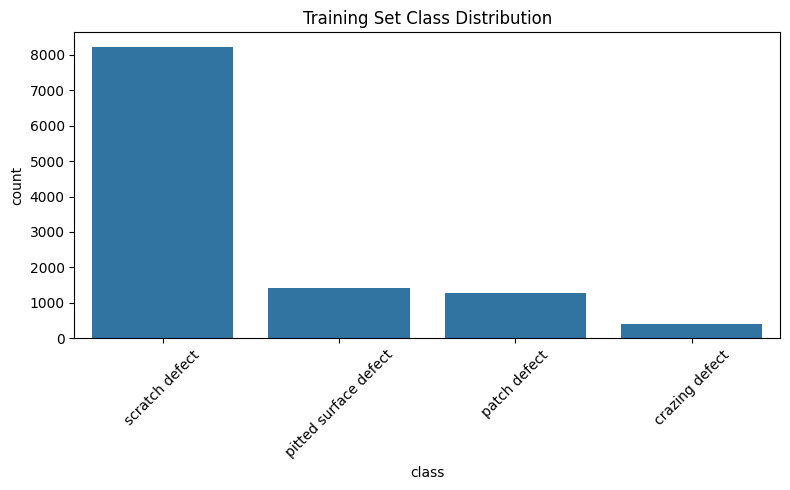

Class Counts:
class
scratch defect           8226
pitted surface defect    1404
patch defect             1282
crazing defect            392
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='class', order=train_df['class'].value_counts().index)
plt.title("Training Set Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_names = list(train_gen.class_indices.keys())

# Display the count of each class separately
class_counts = train_df['class'].value_counts()
print("Class Counts:")
print(class_counts)


In [ ]:
from tensorflow.keras import layers, models

# Define CNN model
def create_cnn_model(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model






In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)

# Map to index format required by model.fit()
class_indices = train_gen.class_indices
weights_dict = {class_indices[cls]: w for cls, w in zip(np.unique(train_df['class']), class_weights)}

#print("Class weights for training:", weights_dict)
print("Class Indices and Weights:")
for cls, index in class_indices.items():
    weight = weights_dict[index]
    print(f"Class: {cls}, Index: {index}, Weight: {weight}")


Class Indices and Weights:
Class: crazing defect, Index: 0, Weight: 7.209183673469388
Class: patch defect, Index: 1, Weight: 2.204368174726989
Class: pitted surface defect, Index: 2, Weight: 2.0128205128205128
Class: scratch defect, Index: 3, Weight: 0.3435448577680525


In [ ]:
BATCH_SIZE = 64

cnn_model = create_cnn_model()

history = cnn_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,  # Ensure correct steps per epoch
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,  # Ensure correct validation steps
    class_weight=weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.2628 - loss: 1.3441 - val_accuracy: 0.2330 - val_loss: 1.2200
Epoch 2/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.3750 - loss: 1.1246

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3750 - loss: 1.1246 - val_accuracy: 0.2344 - val_loss: 1.2072
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.2830 - loss: 1.1857 - val_accuracy: 0.2045 - val_loss: 1.3008
Epoch 4/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 2:45 947ms/step - accuracy: 0.1406 - loss: 0.9938

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.1406 - loss: 0.9938 - val_accuracy: 0.2045 - val_loss: 1.3124
Epoch 5/20
 77/176 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.2520 - loss: 1.1796

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


176/176 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.2632 - loss: 1.1695 - val_accuracy: 0.2003 - val_loss: 1.2574
Epoch 6/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 2:44 938ms/step - accuracy: 0.3750 - loss: 1.3672

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3750 - loss: 1.3672 - val_accuracy: 0.2017 - val_loss: 1.2692
Epoch 7/20
165/176 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2379 - loss: 1.1757

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


176/176 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.2388 - loss: 1.1730 - val_accuracy: 0.2287 - val_loss: 1.2321
Epoch 8/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 2:46 953ms/step - accuracy: 0.2188 - loss: 0.9965

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2188 - loss: 0.9965 - val_accuracy: 0.2315 - val_loss: 1.2228
Epoch 9/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.2508 - loss: 1.1297 - val_accuracy: 0.2756 - val_loss: 1.1109
Epoch 10/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 3:57 1s/step - accuracy: 0.2344 - loss: 0.9892

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2344 - loss: 0.9892 - val_accuracy: 0.2756 - val_loss: 1.1078
Epoch 11/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.2507 - loss: 1.1025 - val_accuracy: 0.5881 - val_loss: 1.0984
Epoch 12/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 2:45 944ms/step - accuracy: 0.3750 - loss: 1.4038

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3750 - loss: 1.4038 - val_accuracy: 0.5795 - val_loss: 1.1170
Epoch 13/20
134/176 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3054 - loss: 1.0968

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src

176/176 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.3020 - loss: 1.0945 - val_accuracy: 0.4247 - val_loss: 1.0527
Epoch 14/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 2:43 935ms/step - accuracy: 0.4844 - loss: 1.0205

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4844 - loss: 1.0205 - val_accuracy: 0.4062 - val_loss: 1.0550
Epoch 15/20
 32/176 ━━━━━━━━━━━━━━━━━━━━ 2:48 1s/step - accuracy: 0.3456 - loss: 0.9861

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src

176/176 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.3226 - loss: 1.0353 - val_accuracy: 0.3750 - val_loss: 1.0461
Epoch 16/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 4:02 1s/step - accuracy: 0.3750 - loss: 1.1269

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3750 - loss: 1.1269 - val_accuracy: 0.3920 - val_loss: 1.0350
Epoch 17/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.3452 - loss: 1.0075 - val_accuracy: 0.4418 - val_loss: 1.1168
Epoch 18/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.4219 - loss: 0.9359

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.4219 - loss: 0.9359 - val_accuracy: 0.4361 - val_loss: 1.1238
Epoch 19/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.3363 - loss: 0.9955 - val_accuracy: 0.3679 - val_loss: 1.0736
Epoch 20/20
  1/176 ━━━━━━━━━━━━━━━━━━━━ 2:38 907ms/step - accuracy: 0.1875 - loss: 0.7153

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1875 - loss: 0.7153 - val_accuracy: 0.3778 - val_loss: 1.0623


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.3620 - loss: 1.0665

 Test accuracy (from evaluate): 0.3607
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step

 Classification Report:
                       precision    recall  f1-score   support

       crazing defect       0.20      0.71      0.31        24
         patch defect       0.23      0.90      0.37        84
pitted surface defect       0.24      0.39      0.30        89
       scratch defect       0.88      0.25      0.39       510

             accuracy                           0.36       707
            macro avg       0.39      0.56      0.34       707
         weighted avg       0.70      0.36      0.37       707

 Overall Accuracy:  0.3607
 Precision:  0.7004
 Recall:     0.3607
 F1 Score : 0.3717


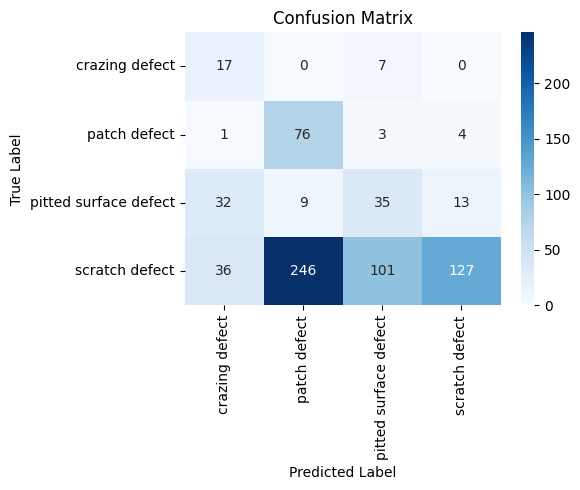

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_gen)
print(f"\n Test accuracy (from evaluate): {test_acc:.4f}")

# Predictions
y_pred = cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# overall metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f" Overall Accuracy:  {accuracy:.4f}")
print(f" Precision:  {precision:.4f}")
print(f" Recall:     {recall:.4f}")
print(f" F1 Score : {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
#After decreasing number of images in any class of training dataset to less than 1000

In [ ]:
IMG_SIZE = (128,128)
BATCH_SIZE = 64

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.2,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    , brightness_range=[0.7, 1.3]
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
import pandas as pd

# Count samples per class
min_samples = 1000
balanced_df = (
    train_df.groupby('class')
    .apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))
    .reset_index(drop=True)
)

print("Before balancing:", train_df['class'].value_counts())
print("After balancing:", balanced_df['class'].value_counts())
train_df = balanced_df

Before balancing: class
scratch defect           8226
pitted surface defect    1404
patch defect             1282
crazing defect            392
Name: count, dtype: int64
After balancing: class
patch defect             1000
pitted surface defect    1000
scratch defect           1000
crazing defect            392
Name: count, dtype: int64


/tmp/ipython-input-26-2918817390.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3392 validated image filenames belonging to 4 classes.
Found 710 validated image filenames belonging to 4 classes.
Found 707 validated image filenames belonging to 4 classes.


In [ ]:
input_shape = (128,128,3)


def create_cnn_model(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


cnn_model = create_cnn_model()



In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)

# Map to class indices
class_indices = train_gen.class_indices
weights_dict = {class_indices[cls]: weight for cls, weight in zip(np.unique(train_df['class']), class_weights)}

# Train the model with weights
history = cnn_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    epochs=20,  # Keep low for speed
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    class_weight=weights_dict
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 687ms/step - accuracy: 0.4063 - loss: 1.1533 - val_accuracy: 0.3040 - val_loss: 1.2023
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.4140 - loss: 1.1071 - val_accuracy: 0.2415 - val_loss: 1.2515
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4175 - loss: 1.1153 - val_accuracy: 0.2614 - val_loss: 1.1932
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 768ms/step - accuracy: 0.4347 - loss: 1.1103 - val_accuracy: 0.2727 - val_loss: 1.3702
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - accuracy: 0.4591 - loss: 1.0893 - val_accuracy: 0.4261 - val_loss: 1.1421
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 674ms/step - accuracy: 0.4637 - loss: 1.0724 - val_accuracy: 0.4403 - val_loss: 1.0601
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 657ms/step - accuracy: 0.4594 - loss: 1.0742 - val_accuracy: 0.3807 - val_loss: 1.1775
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4585 - loss: 1.0621 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src

53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4833 - loss: 1.0240 - val_accuracy: 0.4034 - val_loss: 1.1295
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 675ms/step - accuracy: 0.5196 - loss: 0.9882 - val_accuracy: 0.3324 - val_loss: 1.1301
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - accuracy: 0.5297 - loss: 0.9819 - val_accuracy: 0.3679 - val_loss: 1.1775
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 698ms/step - accuracy: 0.5154 - loss: 0.9827 - val_accuracy: 0.5469 - val_loss: 0.9402
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5527 - loss: 0.9356 - val_accuracy: 0.4134 - val_loss: 1.1237
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 757ms/step - accuracy: 0.5382 - loss: 0.9593 - val_accuracy: 0.4403 - val_loss: 1.0280
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 768ms/step - accuracy: 0.5379 - loss: 0.9665 - val_accuracy: 0.4659 - val_loss: 1.0583
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 781ms/step - accuracy: 0.5574 - loss: 0.9377 - val_accuracy: 0.39

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.4050 - loss: 1.1267

 Test accuracy (from evaluate): 0.4243
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step

 Classification Report:
                       precision    recall  f1-score   support

       crazing defect       0.18      0.83      0.29        24
         patch defect       0.35      0.86      0.50        84
pitted surface defect       0.25      0.63      0.36        89
       scratch defect       0.93      0.30      0.45       510

             accuracy                           0.42       707
            macro avg       0.43      0.65      0.40       707
         weighted avg       0.75      0.42      0.44       707

 Overall Accuracy:  0.4243
 Precision:  0.7515
 Recall:     0.4243
 F1 Score : 0.4396


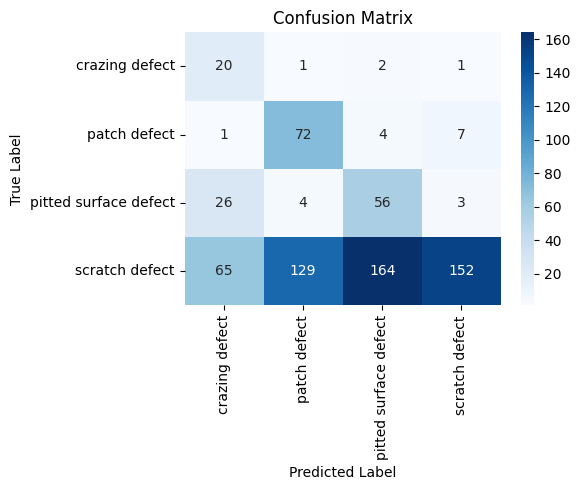

In [ ]:
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_gen)
print(f"\n Test accuracy (from evaluate): {test_acc:.4f}")

# Predictions
y_pred = cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# overall metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f" Overall Accuracy:  {accuracy:.4f}")
print(f" Precision:  {precision:.4f}")
print(f" Recall:     {recall:.4f}")
print(f" F1 Score : {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

